In [2]:
#importazione del df
import pandas as pd
df = pd.read_csv('csv/serie_storica.csv')
df.head()

,DATA,TOTALE
0,2015-01-01,2508
1,2015-01-02,2079
2,2015-01-03,2107
3,2015-01-04,2135
4,2015-01-05,2199


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2008 entries, 0 to 2007
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATA    2008 non-null   object
 1   TOTALE  2008 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.5+ KB


In [4]:
# converto le date
df['DATA'] = pd.to_datetime(df['DATA'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2008 entries, 0 to 2007
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATA    2008 non-null   datetime64[ns]
 1   TOTALE  2008 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 31.5 KB


In [5]:
#metto il campo 'Data' come indice
df=df.set_index('DATA')
df.head()

,TOTALE
DATA,
2015-01-01,2508
2015-01-02,2079
2015-01-03,2107
2015-01-04,2135
2015-01-05,2199


In [6]:
# creazione della serie storica
ts = df.TOTALE
ts.head()

DATA
2015-01-01    2508
2015-01-02    2079
2015-01-03    2107
2015-01-04    2135
2015-01-05    2199
Name: TOTALE, dtype: int64

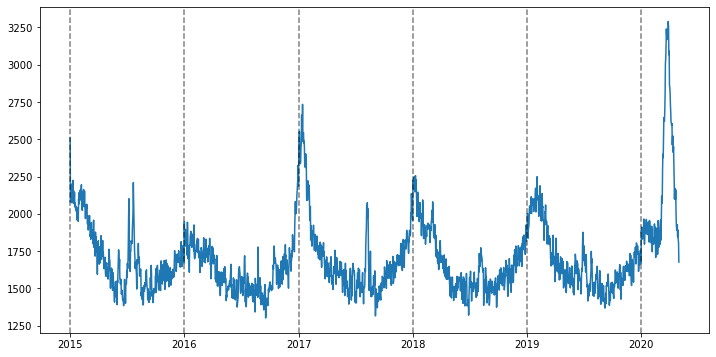

In [7]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,4,30)
lim_ts = ts[start_date:end_date]

#visulizzo il grafico della time series
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

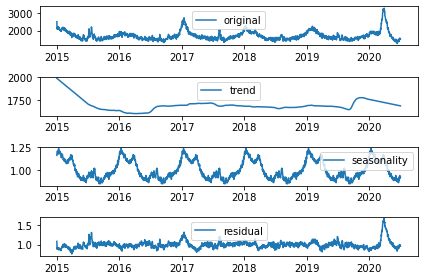

In [8]:
#decomposizione della serie in trend, stagionalità e residui
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=365, two_sided=True, extrapolate_trend=1, model='multiplicative')

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
    else:
        print("X is not stationary")
        

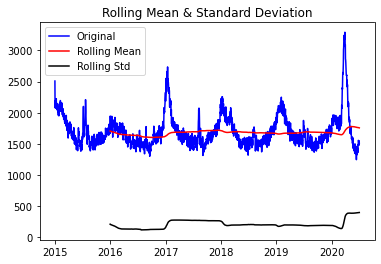

Results of Dickey-Fuller Test:
Test Statistic                -6.766066e+00
p-value                        2.715242e-09
#Lags Used                     0.000000e+00
Number of Observations Used    2.007000e+03
Critical Value (1%)           -3.433612e+00
Critical Value (5%)           -2.862981e+00
Critical Value (10%)          -2.567537e+00
dtype: float64
X is stationary


In [10]:
#verifico che la serie storica sia stazionaria
test_stationarity(ts)

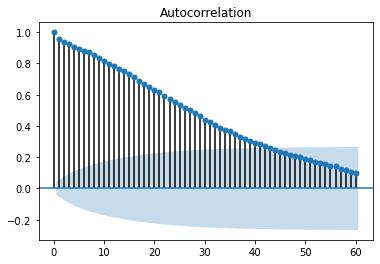

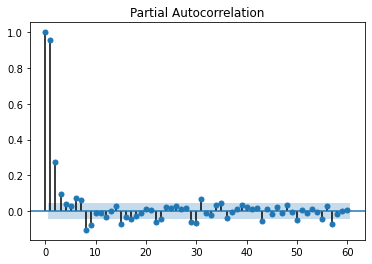

In [11]:
#grafici di autocorrelazione e autocorrelazione parziale
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =60)
plot_pacf(ts, lags =60)
plt.show()

In [12]:
#suddivisione del trend della serie in train e test
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,4,30)

#TEST: dal 01-01-2015 al 31-10-2019
train = ts[:train_end]

#TRAIN: dal 01-11-2019 al 31-12-2019
test = ts[train_end + timedelta(days=1): test_end]


In [13]:
#creazione del modello
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
p = 1 #provare con p=40
q = 8
d = 0
model = ARIMA(train, order=(p,d,q))
model_fit = model.fit(disp=-1)
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequ

                              ARMA Model Results                              
Dep. Variable:                 TOTALE   No. Observations:                 1765
Model:                     ARMA(1, 8)   Log Likelihood               -9960.640
Method:                       css-mle   S.D. of innovations             68.287
Date:                Wed, 21 Oct 2020   AIC                          19943.281
Time:                        15:36:44   BIC                          20003.516
Sample:                    01-01-2015   HQIC                         19965.538
                         - 10-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1698.8082     65.566     25.910      0.000    1570.301    1827.316
ar.L1.TOTALE     0.9879      0.004    222.224      0.000       0.979       0.997
ma.L1.TOTALE    -0.3628      0.025    -14.78

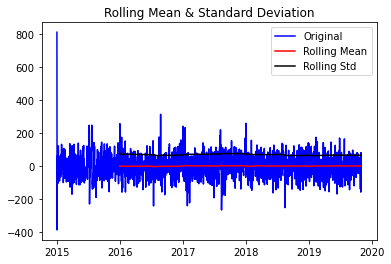

Results of Dickey-Fuller Test:
Test Statistic                  -45.043835
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1764.000000
Critical Value (1%)              -3.434062
Critical Value (5%)              -2.863180
Critical Value (10%)             -2.567643
dtype: float64
X is stationary


In [14]:
#verifico che i residui del modello siano stazionari
residuals = model_fit.resid
test_stationarity(residuals)

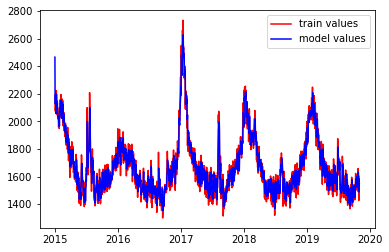

In [15]:
plt.plot (train.iloc[1:], color='red', label='train values')
plt.plot (model_fit.fittedvalues.iloc[1:], color = 'blue', label='model values')

plt.legend()
plt.show()

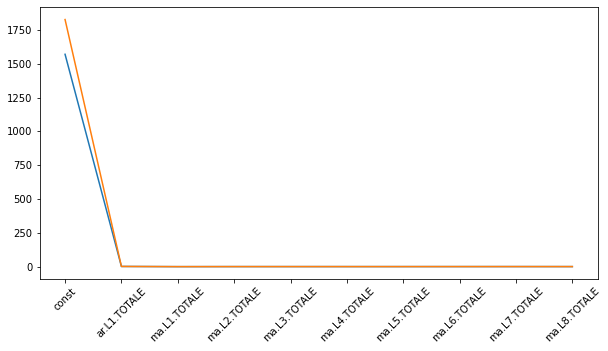

In [16]:
#Intervallo di confidenza del modello
conf = model_fit.conf_int()
plt.figure(figsize=(10,5))
plt.plot(conf)
plt.xticks(rotation=45)
plt.show()

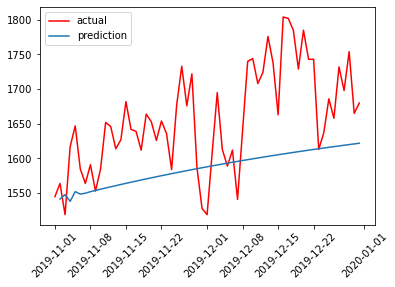

In [17]:
#get prediction start and end dates
pred_start = test.index[0]
pred_end = test.index[-1]

#predizione del modello sul test
predictions_test= model_fit.predict(start=pred_start, end=pred_end)

plt.plot(test, color='red', label='actual')
plt.plot(predictions_test.iloc[1:], label='prediction' )
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [18]:
predictions_test

2019-11-01    1544.326587
2019-11-02    1541.539009
2019-11-03    1547.891647
2019-11-04    1538.134522
2019-11-05    1552.208411
                 ...     
2019-12-27    1618.073002
2019-12-28    1619.050554
2019-12-29    1620.016270
2019-12-30    1620.970293
2019-12-31    1621.912764
Freq: D, Length: 61, dtype: float64

In [19]:
test

DATA
2019-11-01    1545
2019-11-02    1564
2019-11-03    1519
2019-11-04    1617
2019-11-05    1647
              ... 
2019-12-27    1732
2019-12-28    1698
2019-12-29    1754
2019-12-30    1665
2019-12-31    1680
Name: TOTALE, Length: 61, dtype: int64

In [20]:
#calcolo RMSE
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions_test, test)/(np.max(test)-np.min(test))
print('RMSE = ', nrmse)

RMSE =  0.32966089700460804


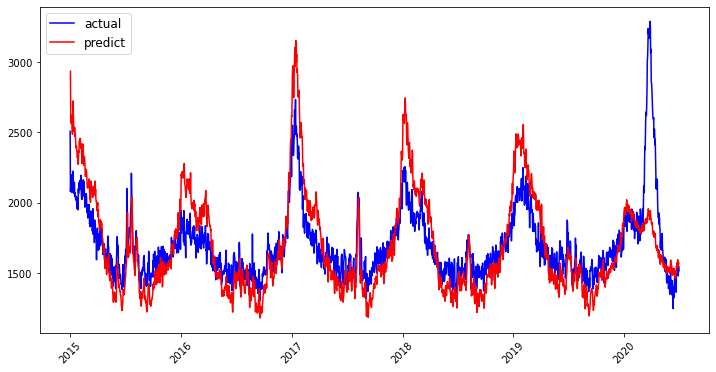

In [21]:
#get prediction start and end dates
start_prediction = ts.index[0]
end_prediction = ts.index[-1]

# predizione sul trend della serie storica includendo il 2020
predictions = model_fit.predict(start=start_prediction, end=end_prediction)

predictions_tot = predictions * ts_seasonal

plt.figure(figsize=(12,6))
plt.plot(ts, color='blue', label='actual')
plt.plot(predictions_tot.iloc[1:], color='red', label='predict')
plt.xticks(rotation=45)
plt.legend(prop={'size': 12})
plt.show()

In [23]:
predictions_tot.to_csv('csv/predictions_daily_ARIMA_7357comuni.csv')

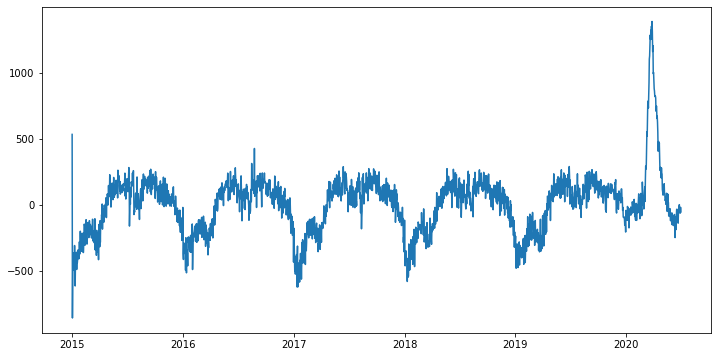

In [25]:
diff_predictions_tot = (ts - predictions_tot)
plt.figure(figsize=(12,6))
plt.plot(diff_predictions_tot)
plt.show()

In [26]:
diff_predictions_tot['24-02-2020':].sum()

39191.7354548061